In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../../1_dock')
sys.path.append('../../3_analyze')
sys.path.append('../../ifp')
sys.path.append('../../mcss')
from containers import Protein
from shared_paths import shared_paths

assert shared_paths['docking'] == 'confgen_es4'

In [2]:
datasets = [d for d in sorted(os.listdir(shared_paths['data']))
            if d[0] != '.' and d[-3:] != 'old']

In [3]:
data = {}
for i, d in enumerate(datasets):
    print(i, d)
    protein = Protein(d)
    lm = protein.lm
    ligands = lm.docked(lm.pdb)[:20]
    protein.load_docking(ligands, False, False, False)
    lm.mcss.load_mcss()
    crystal_lig = "{}_lig".format(lm.st)
    for ligand in ligands:
        if ligand == crystal_lig: continue
        rmsds = [pose.rmsd for pose in protein.docking[lm.st].ligands[ligand].poses]
        if d not in data: data[d] = {}
        data[d][ligand] = rmsds

(0, '5HT2B')
(1, 'A2AR')
(2, 'AR')
(3, 'B1AR')
(4, 'B2AR')
(5, 'BRAF')
(6, 'CDK2')
(7, 'CHK1')
(8, 'DTRANSP')
(9, 'ERA')
(10, 'GCR')
(11, 'GLUT1')
(12, 'JAK2')
(13, 'M3')
(14, 'MEK1')
(15, 'MGLUR5')
(16, 'MR')
(17, 'O60885')
(18, 'P00489')
(19, 'P00734')
(20, 'P00742')
(21, 'P00749')
(22, 'P00760')
(23, 'P03951')
(24, 'P07900')
(25, 'P18031')
(26, 'P24941')
(27, 'P56817')
(28, 'PLK1')
(29, 'Q16539')
(30, 'Q9Y233')
(31, 'SIGMA1')
(32, 'SMO')
(33, 'STRANSP')
(34, 'TRPV1')
(35, 'VITD')


In [4]:
print len(data)
print sum([len(v) for k, v in data.items()])
for count, key in sorted([(len(v), k) for k, v in data.items()]):
    print count, key

36
477
1 5HT2B
1 M3
1 SIGMA1
1 TRPV1
2 GLUT1
4 MGLUR5
4 SMO
4 STRANSP
7 B2AR
8 DTRANSP
10 AR
11 B1AR
11 MR
11 PLK1
12 P24941
13 P03951
16 O60885
17 A2AR
18 GCR
19 BRAF
19 ERA
19 JAK2
19 MEK1
19 P00489
19 P00734
19 P00742
19 P00749
19 P00760
19 P07900
19 P18031
19 P56817
19 Q16539
19 Q9Y233
19 VITD
20 CDK2
20 CHK1


(array([  23.,   16.,    7.,   29.,   27.,   25.,   26.,   49.,   87.,  188.]),
 array([   1. ,   30.9,   60.8,   90.7,  120.6,  150.5,  180.4,  210.3,
         240.2,  270.1,  300. ]),
 <a list of 10 Patch objects>)

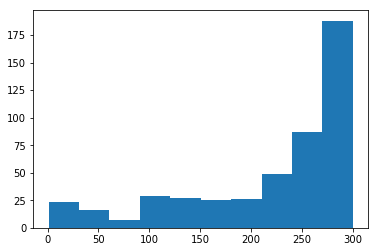

In [5]:
lengths = [len(rmsds)
           for prot, ligands in data.items()
           for ligand, rmsds in ligands.items()]
plt.hist(lengths)

# Glide performance for all ligands

In [6]:
def percentage_native(rmsds, poses = 1, thresh = 2.0):
    hit, total = 0.0, 0.0
    for rmsd in rmsds:
        if None in rmsd: continue
        hit   += any(rmsd[:poses] < thresh)
        total += 1
    return hit / total

class Table:
    def __init__(self, columns):
        self.columns = columns
    
    def __call__(self, data):
        s = ''
        for width, d in zip(self.columns, data):
            d = str(d)[:width-1]
            s += str(d).ljust(width, ' ')
        print s

def performance(rmsds):

    POSE = [0, 1, 3, 10, 30, 100, 300]
    THRESH = [1, 1.5, 2, 2.5, 3, 3.5, 4, 8]

    for thresh in THRESH:
        Y = [percentage_native(rmsds, poses, thresh)
             for poses in POSE]
        plt.plot(Y, label = "< {} rmsd".format(thresh))
    plt.xticks(range(len(POSE)),POSE)
    plt.legend(loc = 4)
    plt.ylabel('Fraction Correct')
    plt.xlabel('Number of Poses Considered')
    plt.title('All Proteins')
    plt.ylim(0, 1)
    plt.xlim(0, len(POSE)-1)
    plt.show()

    # Table
    potential = Table([10]*4)
    potential(['RMSD', 'top 1', 'top 100', 'Potential'])

    for thresh in THRESH:
        potential([thresh,
                   percentage_native(rmsds, 1, thresh),
                   percentage_native(rmsds, 100, thresh), 
                   percentage_native(rmsds, 100, thresh) - percentage_native(rmsds, 1, thresh)
                  ])

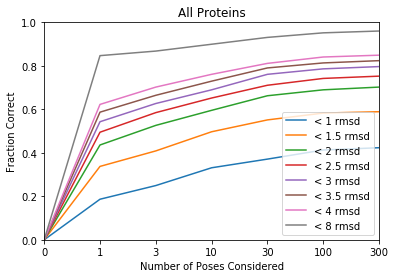

RMSD      top 1     top 100   Potential 
1         0.1865828 0.4129979 0.2264150 
1.5       0.3375262 0.5828092 0.2452830 
2         0.4360587 0.6897274 0.2536687 
2.5       0.4947589 0.7421383 0.2473794 
3         0.5429769 0.7861635 0.2431865 
3.5       0.5870020 0.8134171 0.2264150 
4         0.6226415 0.8406708 0.2180293 
8         0.8469601 0.9517819 0.1048218 


In [7]:
rmsds = [np.array(rmsds)
         for prot, ligands in data.items()
         for ligand, rmsds in ligands.items()]
performance(rmsds)

# Glide performance averaged over targets

In [8]:
def target_performance(top1, top100, labels):
    print 'Top pose is correct', sum(top1) / float(len(top1))
    print 'Top 100 has one correct', sum(top100) / float(len(top100))

    markers = ['o', 'v', 'x', 's']
    f, ax = plt.subplots()
    for i, (_x, _y, _label) in enumerate(zip(top1, top100, labels)):
        plt.scatter(_x, _y, marker = markers[i/10], label = _label)
    plt.xlabel('Top 1', fontsize = 16)
    plt.ylabel('Top 100', fontsize = 16)
    plt.plot(range(2), linestyle='--', c = 'k')
    plt.title('Fraction Near-Native', fontsize = 20)
    ax.set_aspect('equal', 'box')
    plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=2)
    plt.show()

Top pose is correct 0.432653175213
Top 100 has one correct 0.72757249869


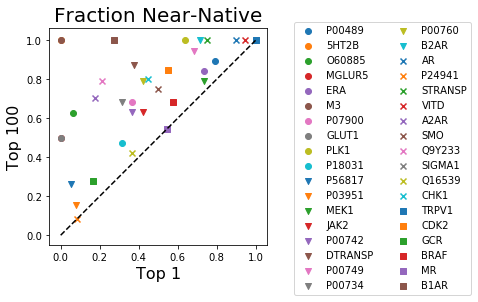

In [9]:
# GScore
top1, top100, labels = [], [], []
for prot, ligands in data.items():
    rmsds = [np.array(rmsds)
             for ligand, rmsds in ligands.items()]
    top1 += [percentage_native(rmsds, 1, 2.0)]
    top100 += [percentage_native(rmsds, 100, 2.0)]
    labels += [prot]
target_performance(top1, top100, labels)